In [1]:
import copy
import gym
import numpy as np
from numpy import random
import matplotlib.pyplot as plt

%matplotlib inline

env = gym.make('Taxi-v2')
s = env.reset()

In [2]:
class trj_arc:
    def __init__(self):
        self.incoming = {} #int variable -> int action index
        self.outgoing = {} #int -> set(int)


class node:
    def __init__(self, state, action, reward):
        self.action = action
        self.reward = reward
        self.state = state # после данного действия
        self.causal_arcs = trj_arc()


class cat:
    def __init__(self):
        self._trajectory = [] # list(node)

        
    def incoming_variables(self, action_indices):
        variables = set()
        for ai in action_indices:
            in_vars = list(self._trajectory[ai].causal_arcs.incoming.keys())
            for v in in_vars:
                variables.add(v)
        return variables

    
    def outgoing_variables(self, action_indices):
        variables = set()
        for ai in action_indices:
            out_vars = list(self._trajectory[ai].causal_arcs.outgoing.keys())
            for v in out_vars:
                variables.add(v)
        return variables
    
    
    def cheked_variables(self):
        variables = set()
        for a in range(len(self._trajectory)):
            vars_ = list(self._trajectory[a].causal_arcs.incoming.keys())
            for v in vars_:
                variables.add(v)
        return variables
    
    
    def changed_variables(self):
        variables = set()
        for a in range(len(self._trajectory)):
            vars_ = list(self._trajectory[a].causal_arcs.outgoing.keys())
            for v in vars_:
                variables.add(v)
        return variables

    
    def extract_goal_state(self):
        return self._trajectory[-1].state
    
    
    def extract_state(self, action_index):
        return self._trajectory[action_index].state
    
    
    def extract_action(self, action_index):
        return self._trajectory[action_index].action
    
    
    def goal_variables(self):
        return self.incoming_variables({len(self._trajectory) - 1,})
    

class subcat:
    def __init__(self, outgoing_variables):
        self.action_indices = set()
        self.preconditions = {} # variable -> action_index
        self.outgoing_variables = outgoing_variables # set()

        
    def empty(self):
        return len(self.outgoing_variables) == 0

    
    def clear(self):
        self.outgoing_variables.clear()
        

class action_model:
    def __init__(self, checked_variables=set(), changed_variables=set()):
        self.checked_variables = checked_variables
        self.changed_variables = changed_variables

In [3]:
def getState(s, env, done):
    taxirow, taxicol, passloc, destidx = env.env.decode(s)
    state = {}
    state[0] = taxirow
    state[1] = taxicol
    state[5] = env.env.locs[destidx][0]
    state[6] = env.env.locs[destidx][1]
    if passloc == 4:
        state[3] = taxirow
        state[4] = taxicol
        state[7] = 1
    if done:
        state[7] = 0
    return state


def causallyAnnotation(trj, actions, variables, mu, env, start):
    c = cat()
    s = start
    env.env.s = s
    done = False
    state = getState(s, env, done)
    n = node(state, -1, 0)   # start node
    c._trajectory.append(n)
    last_changed = {i: 0 for i in range(len(variables))}
    for ai in range(len(trj)):
        a = actions[trj[ai]]
        s, reward, done, _ = env.step(a)
        state = getState(s, env, done)
        n = node(state, a, reward)
        for var in mu[a].checked_variables:
            n.causal_arcs.incoming[var] = last_changed[var]
            c._trajectory[last_changed[var]].causal_arcs.outgoing.setdefault(var, set()).add(ai + 1)
        for var in mu[a].changed_variables:
            last_changed[var] = ai + 1
        c._trajectory.append(n)
    state = getState(s, env, done)
    n = node(state, -2, 0)   # end node
    for var in state.keys():
        n.causal_arcs.incoming[var] = last_changed[var]
        c._trajectory[last_changed[var]].causal_arcs.outgoing.setdefault(var, set()).add(len(trj) + 1)
    c._trajectory.append(n)
    return c

In [4]:
variables = ["taxi.x", "taxi.y", "taxi.ful", "pass.loc.x", "pass.loc.y", "pass.dest.x", "pass.dest.y", "pass.intaxi"]
actions = {v: i for i, v in enumerate(["South", "North", "East", "West", "Pickup", "Dropoff"])}

mu = []
mu.append(action_model({1,}, {1,}))
mu.append(action_model({1,}, {1,}))
mu.append(action_model({0, 1}, {0,}))
mu.append(action_model({0, 1}, {0,}))
mu.append(action_model({0, 1, 3, 4, 7}, {7,}))
mu.append(action_model({0, 1, 3, 4, 5, 6, 7}, {7}))

In [5]:
start = 483
trj = ['North', 'North', 'North', 'West', 'West', 'West', 'West', 'North', 'Pickup', 
       'East', 'South', 'East', 'East', 'South', 'South', 'South', 'Dropoff']
c = causallyAnnotation(trj, actions, variables, mu, env, start)

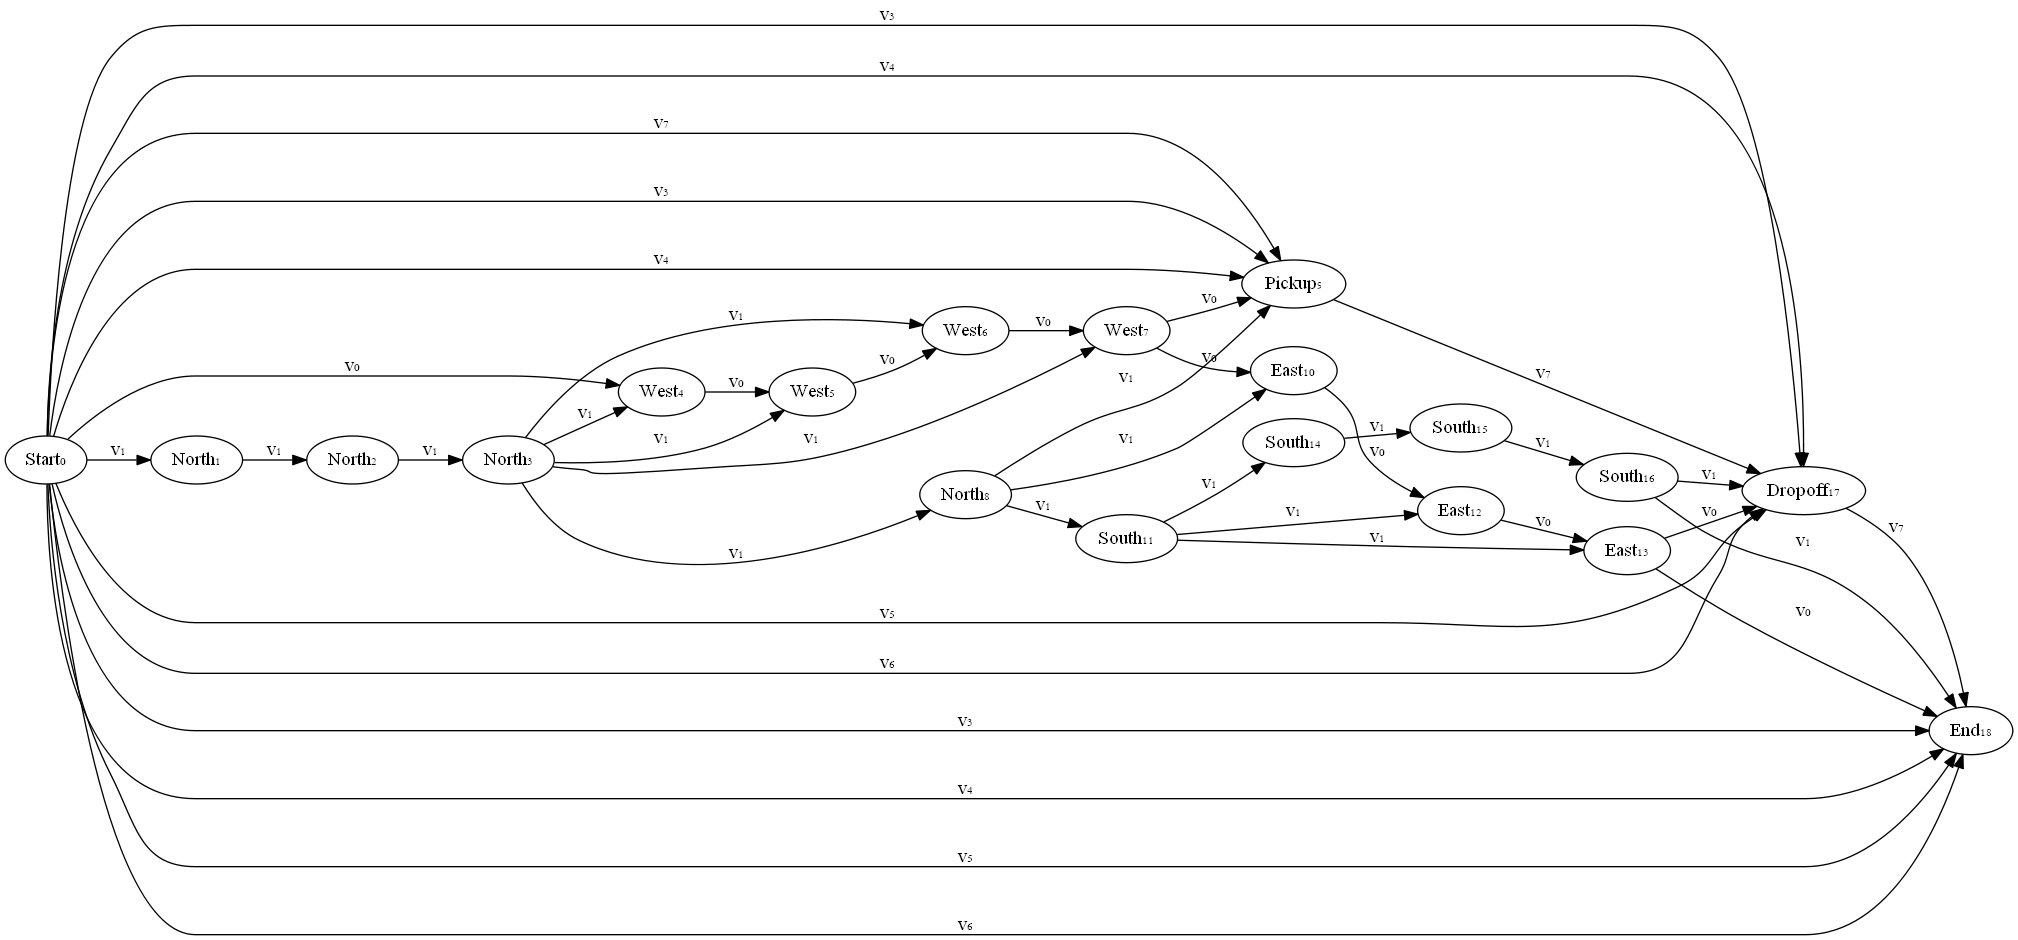

In [6]:
# -*- coding: utf-8 -*-
import pydot
from IPython.display import Image, display
import networkx as nx
import os
os.environ["PATH"] += os.pathsep + 'C:/Program Files (x86)/Graphviz2.38/bin/'

codes = ['\u2080', '\u2081', '\u2082', '\u2083', '\u2084', '\u2085', '\u2086', '\u2087', '\u2088', '\u2089']


def viewTrajectory(CAT, savepath=None):
    actions_names = {i: v for i, v in enumerate(["South", "North", "East", "West", "Pickup", "Dropoff"])}
    actions_names[-1] = "Start"
    actions_names[-2] = "End"
    graph = pydot.Dot(graph_type='digraph', rankdir='LR', inputscale=72, splines="true", 
                      layout="dot", overlap="scale") #neato
    for i in range(len(CAT._trajectory)):
        lab = actions_names[CAT._trajectory[i].action].encode('utf-8')
        if i > 9:
            lab += codes[i // 10].encode('utf-8')
        lab += codes[i % 10].encode('utf-8')
        node = pydot.Node(i, label=lab.decode('cp1251'), x = i * 105, y = 0, pos="%d,50!" % (i * 105))
        graph.add_node(node)
    for i in range(len(CAT._trajectory)):
        for j in CAT._trajectory[i].causal_arcs.outgoing:
            for out in CAT._trajectory[i].causal_arcs.outgoing[j]:
                lab = u"v".encode('utf-8') + codes[j].encode('utf-8')
                edge = pydot.Edge(i, out, label=lab.decode('cp1251'))
                graph.add_edge(edge)
    if savepath:
        graph.write_png(path=savepath)
    else:
        plt = Image(graph.create_png())
        display(plt)


viewTrajectory(c)

In [7]:
t = {i: v for i, v in enumerate(["start", "south", "south", "east", "east", "east", "south", "east", "south", "west", "pickup", 
                                 "east", "north", "west", "north", "west", "west", "west", "north", "north", "dropoff", "end"])}

In [8]:
CAT = cat()
state = {i: 0 for i in range(len(variables))}
reward = 0
n = node(state, -1, reward)
n.causal_arcs.outgoing = {0: {3,}, 1: {1,}, 3: {10, 20, 21}, 4: {10, 20, 21}, 5: {20, 21}, 6: {20, 21}, 7: {10,}}
CAT._trajectory.append(n)

reward = -1
n = node(state, actions['South'], reward)
n.causal_arcs.outgoing = {1: {2,}}
n.causal_arcs.incoming = {1: 0}
CAT._trajectory.append(n)

n = node(state, actions['South'], reward)
n.causal_arcs.outgoing = {1: {3, 4, 5, 6}}
n.causal_arcs.incoming = {1: 1}
CAT._trajectory.append(n)

n = node(state, actions['East'], reward)
n.causal_arcs.outgoing = {0: {4,}}
n.causal_arcs.incoming = {0: 0, 1: 2}
CAT._trajectory.append(n)

n = node(state, actions['East'], reward)
n.causal_arcs.outgoing = {0: {5,}}
n.causal_arcs.incoming = {0: 3, 1: 2}
CAT._trajectory.append(n)

n = node(state, actions['East'], reward)
n.causal_arcs.outgoing = {0: {7,}}
n.causal_arcs.incoming = {0: 4, 1: 2}
CAT._trajectory.append(n)

n = node(state, actions['South'], reward)
n.causal_arcs.outgoing = {1: {7, 8, 9}}
n.causal_arcs.incoming = {1: 2}
CAT._trajectory.append(n)

n = node(state, actions['East'], reward)
n.causal_arcs.outgoing = {0: {9,}}
n.causal_arcs.incoming = {0: 5, 1: 6}
CAT._trajectory.append(n)

n = node(state, actions['South'], reward)
n.causal_arcs.outgoing = {1: {10, 11, 12}}
n.causal_arcs.incoming = {1: 6}
CAT._trajectory.append(n)

n = node(state, actions['West'], reward)
n.causal_arcs.outgoing = {0: {10, 11}}
n.causal_arcs.incoming = {0: 7, 1: 6}
CAT._trajectory.append(n)

n = node(state, actions['Pickup'], reward)
n.causal_arcs.outgoing = {7: {20,}}
n.causal_arcs.incoming = {0: 9, 1: 8, 3: 0, 4: 0, 7: 0}
CAT._trajectory.append(n)

n = node(state, actions['East'], reward)
n.causal_arcs.outgoing = {0: {13,}}
n.causal_arcs.incoming = {0: 9, 1: 8}
CAT._trajectory.append(n)

n = node(state, actions['North'], reward)
n.causal_arcs.outgoing = {1: {13, 14}}
n.causal_arcs.incoming = {1: 8}
CAT._trajectory.append(n)

n = node(state, actions['West'], reward)
n.causal_arcs.outgoing = {0: {15,}}
n.causal_arcs.incoming = {0: 11, 1: 12}
CAT._trajectory.append(n)

n = node(state, actions['North'], reward)
n.causal_arcs.outgoing = {1: {15, 16, 17, 18}}
n.causal_arcs.incoming = {1: 12}
CAT._trajectory.append(n)

n = node(state, actions['West'], reward)
n.causal_arcs.outgoing = {0: {16,}}
n.causal_arcs.incoming = {0: 13, 1: 14}
CAT._trajectory.append(n)

n = node(state, actions['West'], reward)
n.causal_arcs.outgoing = {0: {17,}}
n.causal_arcs.incoming = {0: 15, 1: 14}
CAT._trajectory.append(n)

n = node(state, actions['West'], reward)
n.causal_arcs.outgoing = {0: {20, 21}}
n.causal_arcs.incoming = {0: 16, 1: 14}
CAT._trajectory.append(n)

n = node(state, actions['North'], reward)
n.causal_arcs.outgoing = {1: {19,}}
n.causal_arcs.incoming = {1: 14}
CAT._trajectory.append(n)

n = node(state, actions['North'], reward)
n.causal_arcs.outgoing = {1: {20, 21}}
n.causal_arcs.incoming = {1: 18}
CAT._trajectory.append(n)

n = node(state, actions['Dropoff'], reward)
n.causal_arcs.outgoing = {7: {21,}}
n.causal_arcs.incoming = {0: 17, 1: 19, 3: 0, 4: 0, 5: 0, 6: 0, 7: 10}
CAT._trajectory.append(n)

n = node(state, -2, 20)
n.causal_arcs.incoming = {0: 17, 1: 19, 3: 0, 4: 0, 5: 0, 6: 0, 7: 20}
CAT._trajectory.append(n)

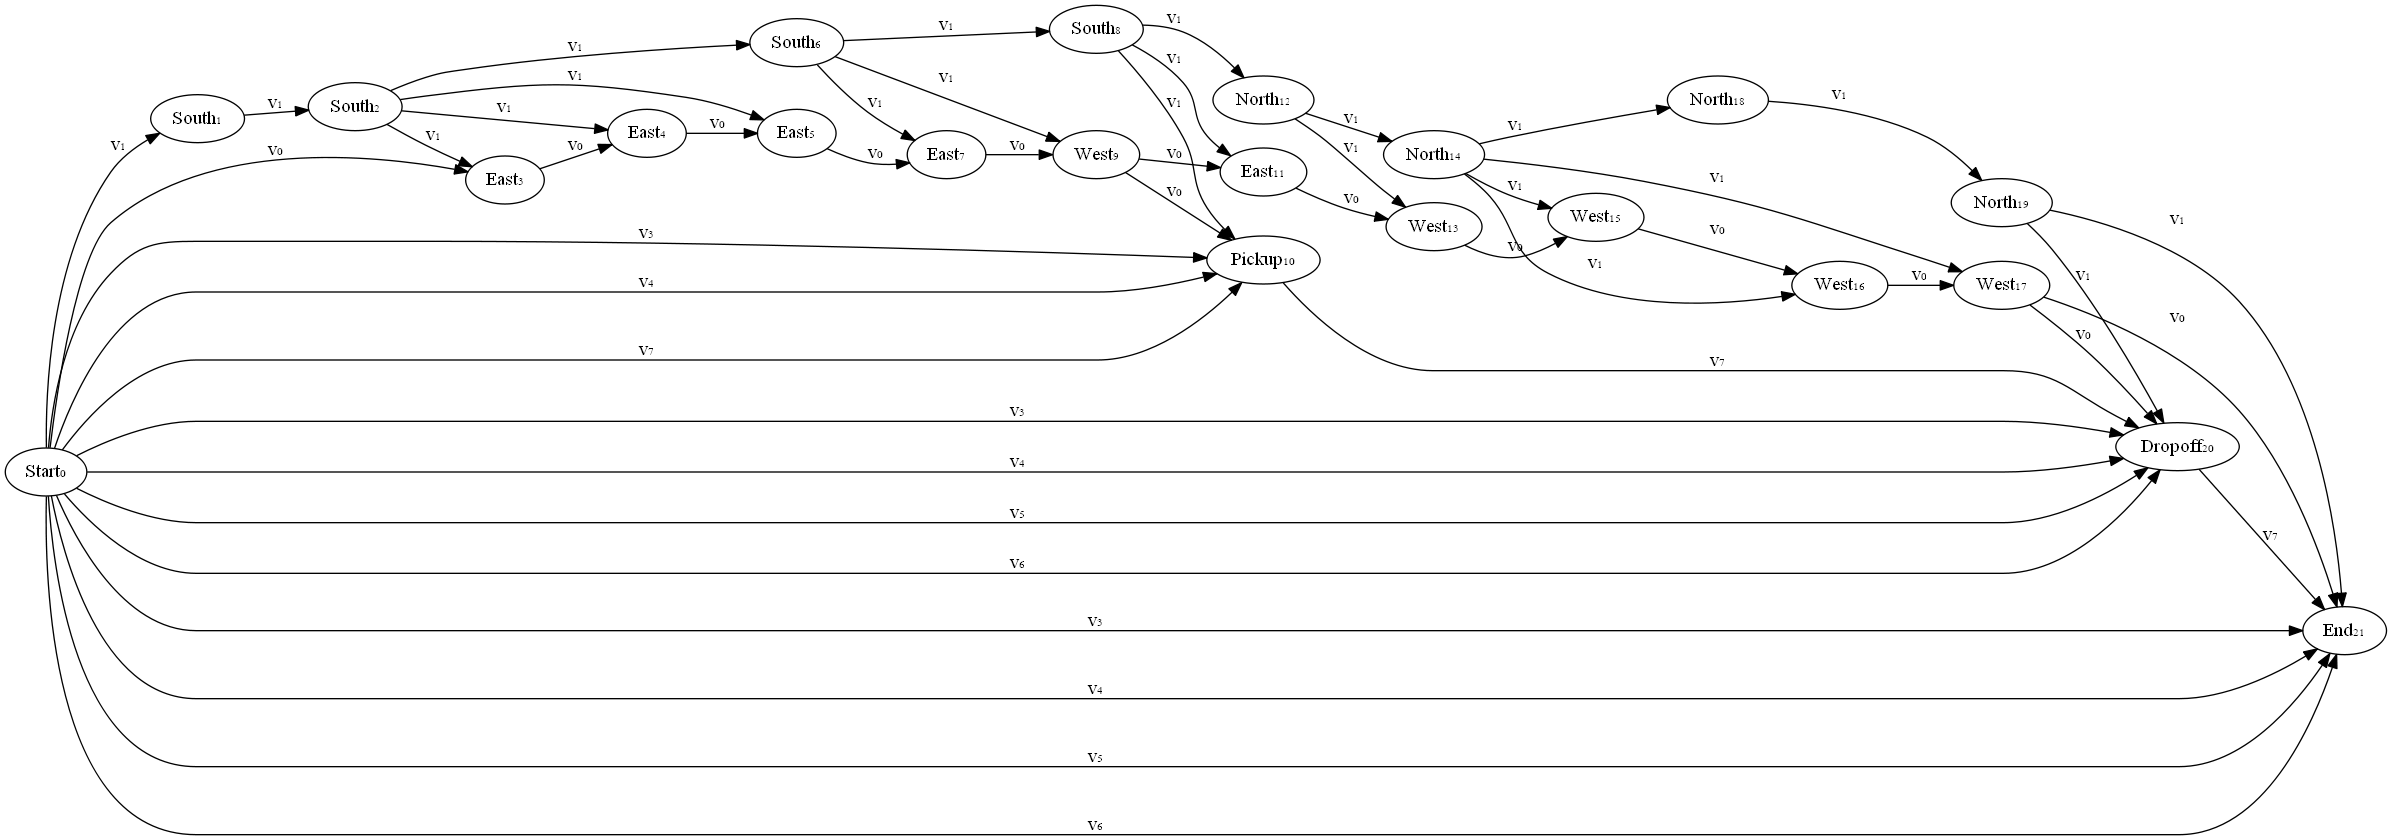

In [9]:
viewTrajectory(CAT)

In [10]:
def uniquePrecondition(psi, w):
    '''
    input: psi - индексы действий в sub-CAT; w -CAT
    output: усечение (входы по переменной из одного действия)
    '''
    pre = {}
    for ai in sorted(psi, reverse=True):
        for v, a in w._trajectory[ai].causal_arcs.incoming.items():
            if a not in psi:
                if pre.get(v, a) == a:
                    pre[v] = a
                else:
                    psi.remove(ai)
                    break
                    
    out = set()
    for ai in psi:
        for v, actions in w._trajectory[ai].causal_arcs.outgoing.items():
            for a in actions:
                if a not in psi:
                    out.add(v)
    psi_subcat = subcat(out)
    psi_subcat.action_indices = psi
    psi_subcat.preconditions = pre
    return psi_subcat


def catScan(omega, V):   # извлечение индексов sub-CATs (psi_w для CAT w)
    '''
    input: omega - set of CATs; V - set of variables
    output: set phi of set of action indeces in omega (исправил на set of set of subcats)
    '''
    psi = []
    for w in omega:
        psi_w = set()
        p = []
        for v in w.goal_variables():
            if v in V:
                a = w._trajectory[-1].causal_arcs.incoming[v]
                if a != 0:
                    psi_w.add(a)
                    p.append(a)
        for ai in p:
            for v, a in w._trajectory[ai].causal_arcs.incoming.items():
                if a != 0:
                    ex = True
                    for out_a in w._trajectory[a].causal_arcs.outgoing.get(v, {-10,}):
                        if out_a not in psi_w:
                            ex = False
                            break
                    if ex and a not in psi_w:
                        psi_w.add(a)
                        p.append(a)
        psi_w = uniquePrecondition(psi_w, w)
        psi.append(psi_w)
    return psi                

In [26]:
def goalCondition(omega):
    '''
    input: omega - set of CATs
    output: goal predicate
    '''
    final_states = []
    for w in omega:
        final_states.append(w.extract_goal_state())
    return generalizedCondition(final_states, omega[0].goal_variables())


def generalizedCondition(states, variables):
    '''
    Find the conditions for variables that are true for the entire set of states
    The family of conditions a variable is: (1) equal to constant, (2) equal to another variable
    
    input: states - set of values of variables; variables - variables of interest
    onuput: famile of conditions
    '''
    all_variables = list(states[0].keys())
    condition_vars = list(variables)
    variables_value = {}
    if len(condition_vars) == 0:
        condition_vars = all_variables[:]
    j = 0
    while j != len(condition_vars):
        v = condition_vars[j]
        val = states[0][v]
        equal_to_value = True
        for s in states:
            if s[v] != val:
                equal_to_value = False
                break
        if equal_to_value:
            variables_value[v] = val
            condition_vars.remove(v)
        else:
            j += 1
        
    equal_variables = []
    for v1 in condition_vars:
        for v2 in all_variables:
            if v1 != v2:
                var_set = {v1, v2}
                equal_to_variable = False
                for ev in equal_variables:
                    if v1 in ev and v2 in ev:
                        equal_to_variable = True
                        break
                if equal_to_variable:
                    continue
                
                equal_to_variable = True
                for s in states:
                    if s[v1] != s[v2]:
                        equal_to_variable = False
                        break
                if equal_to_variable:
                    matching_block_found = False
                    for ev in equal_variables:
                        if v1 in ev or v2 in ev:
                            ev.add(v1)
                            ev.add(v2)
                            matching_block_found = True
                            break
                    if not matching_block_found:
                        equal_variables.append(var_set)
    return variables_value, equal_variables


def multipleActions(omega):
    '''
    input: omega - set of CATs
    output: true, if at least one CAT has multiple actions
    '''
    for w in omega:
        if len(w._trajectory) > 1:
            return True
    return False


def extractUltimateActions(omega): # returns psi - list of ultimate actions in CATs
    '''
    input: omega - set of CATs
    output: set of sub-CATs, that contain the ultimate actions
    '''
    action_indices = []
    for w in omega:
        global_found = False
        for v in w._trajectory[-1].causal_arcs.incoming:
            ai = w._trajectory[-1].causal_arcs.incoming[v]
            found = False
            for var in w._trajectory[ai].causal_arcs.outgoing:
                if w._trajectory[ai].causal_arcs.outgoing[var] != len(w._trajectory) - 1:
                    found = True
                    global_found = True
                    break
            if found:
                action_indices.append(ai)
                break
        if not global_found:
            print('ERROR in ultimate actions')
            action_indices.append(-1)
    return action_indices


def relevantVariables(mu, A, G):
    '''
    input: mu - set of action models; A - set of actions; G - goal condition
    output: variables in mu, G
    '''
    variables_value, equal_variables = G
    rel_vars = set()
    for a in A:
        for v in mu[a].changed_variables:
            if v in equal_variables:
                rel_vars.add(v)
            f = False
            for equal_set in equal_variables:
                if v in equal_set:
                    rel_vars.add(v)
                    f = True
                    break
    return rel_vars


def unify(Psi, omega): # trajectories = omega, matrix = Psi
    '''
    input: Psi
    output: set of merged sub-CATs так, что затронутые переменные разделены в Psi (глобальное разделение, удовл. всем CATs)
    '''
    if len(Psi) < 2:
        return Psi
    
    global_factors = []
    local_factors = [] # мн-во мн-в переменных в subCAT построенных по переменным для каждого CAT
    for t in range(len(omega)):
        local_factors.append([])
        for psi in Psi:
            factor = set()
            if psi[t].action_indices:
                for el in psi[t].outgoing_variables: #& variables:
                    factor.add(el)
            local_factors[-1].append(factor)
                
        if len(global_factors) == 0:
            global_factors = local_factors[-1]
        else:
            for k in range(len(Psi)):
                global_factors[k] = global_factors[k] | local_factors[-1][k]
                
    for gf in range(len(global_factors) - 1):
        if len(global_factors[gf]) != 0:
            new_factor = global_factors[gf].copy()
            global_factors[gf].clear()
            fi = gf
            for f in range(gf + 1, len(global_factors)):
                if len(new_factor & global_factors[f]) != 0:
                    new_factor = new_factor | global_factors[f]
                    global_factors[f].clear()
                    fi = f
            global_factors[fi] = new_factor
            
    for t in range(len(omega)):
        for f in range(len(global_factors)):
            if len(global_factors[f]) != 0:
                action_indices = set()
                nonempty_subtrj = 0
                cleaner = set()
                for lf in range(f + 1):
                    if len(local_factors[t][lf]) != 0 and local_factors[t][lf].issubset(global_factors[f]):
                        action_indices = action_indices | Psi[lf][t].action_indices
                        # termination
                        nonempty_subtrj = lf
                        cleaner.add(lf) 
                if len(action_indices) != 0:
                    if len(action_indices) == 1:
                        if nonempty_subtrj != f:
                            Psi[f][t] = Psi[nonempty_subtrj][t]
                    else:
                        Psi[f][t] = uniquePrecondition(action_indices, omega[t])
    return Psi


def merge(Psi, omega):
    '''
    input:
    output: объединяет элементы в Psi в один, извлекая sub-CATs, которые влияют на переменные в Psi (используя catScan)
    '''
    for t in range(len(omega)):
        nonempty_subtrj = 0
        new_action_indices = set()
        for v in range(len(Psi)): # переменные в Psi
            if Psi[v][t].action_indices:
                new_action_indices = new_action_indices | Psi[v][t].action_indices
                nonempty_subtrj = v
                
        if len(new_action_indices) != 0:
            if len(new_action_indices) == 1:
                Psi[-1][t] = Psi[nonempty_subtrj][t]
            else:
                Psi[-1][t] = uniquePrecondition(new_action_indices, omega[t])


def extract(omega, action_indices):
    '''
    input: omega - set of CATs; psi - индексы действий в sub-CAT
    output: "new" omega (sub-CATs)
    '''
    new_omega = []
    for t in range(len(action_indices)):
        action_indices[t] = sorted(list(action_indices[t]))
        
    for t in range(len(omega)):
        act_ind = {action_indices[t][j]: j + 1 for j in range(len(action_indices[t]))}
        state = {i: 0 for i in range(len(variables))}
        trj = [node(state, -1, 0)]
        end = node(state, -2, 0)
        end.causal_arcs.outgoing = set()
        CAT = copy.deepcopy(omega[t])
        for j, ai in enumerate(action_indices[t], 1):
            trj.append(CAT._trajectory[ai])
            trj[j].causal_arcs.outgoing = {}
            for v in trj[j].causal_arcs.incoming:
                if trj[j].causal_arcs.incoming[v] not in act_ind:
                    trj[j].causal_arcs.incoming[v] = 0
                    trj[0].causal_arcs.outgoing.setdefault(v, set()).add(j)
                    trj[0].state[v] = trj[j].state[v]
                else:
                    fr = act_ind[trj[j].causal_arcs.incoming[v]]
                    trj[j].causal_arcs.incoming[v] = fr
                    trj[fr].causal_arcs.outgoing.setdefault(v, set()).add(j)
            for v in omega[t]._trajectory[ai].causal_arcs.outgoing:
                for a in omega[t]._trajectory[ai].causal_arcs.outgoing[v]:
                    if a not in act_ind:
                        trj[j].causal_arcs.outgoing.setdefault(v, set()).add(len(act_ind) + 1)
                        end.causal_arcs.incoming[v] = j
                        end.state[v] = trj[j].state[v]
                        break
        trj.append(end)
        new_omega.append(cat())
        new_omega[t]._trajectory = trj
        return new_omega


def abstraction(Psi, omega, q, mu): #p. 70 - не нужно
    '''
    input:
    output:
    '''
    actions = set()
    goal_variables = set()
    for t in range(len(Psi[q])):
        for ind in Psi[q][t].action_indices:
            actions.add(omega[t].extract_action(ind))
        goal_variables = goal_variables | Psi[q][t].outgoing_variables
    
    while True:
        next_stage_closure_variables = goal_variables.copy()
        for action in actions:
            next_stage_closure_variables_per_action = closure_next_stage(action, goal_variables)
            next_stage_closure_variables = next_stage_closure_variables | next_stage_closure_variables_per_action
        
        if next_stage_closure_variables_per_action == goal_variables:
            break
        goal_variables = next_stage_closure_variables_per_action
    return goal_variables            


def primitive_descendats(C):
    if isinstance(C[0], int):
        return C
    else:
        desc = set()
        for c in C:
            pr_desc = primitive_descendats(c[2])
            for el in pr_desc:
                desc.add(el)
        return desc


def cats_actions(omega):
    actions = set()
    for c in omega:
        for ai in range(len(c._trajectory)):
            action = c.extract_action(ai)
            if action != -1 and action != -2:
                actions.add(c.extract_action(ai))
    return list(actions)


def previousActionIndices(psi):
    min_ind = []
    for t in range(len(omega)):
        if len(psi[t].action_indices) != 0:
            min_ind.append(min(psi[t].action_indices))
        else:
            min_ind.append(0)
    psi_ = [{i for i in range(1, min_ind[t])} for t in range(len(omega))]
    return psi_


def anotherActionIndices(psi):
    psi_ = [{i for i in range(1, len(omega[t]._trajectory) - 1)} for t in range(len(omega))]
    for t in range(len(omega)):
        ai = psi[t]
        psi_[t].discard(ai)
    return psi_

In [12]:
local_factors = [[{1, 2}, {3,}, ], [[{1,}, {2, 3}]]]
global_factors = [{1, 2, 5}, {2, 3, 6}, {-1, -2, 1}, {8, 9}, {9, 10}, {3}]
for gf in range(len(global_factors) - 1):
    if len(global_factors[gf]) != 0:
        new_factor = global_factors[gf].copy()
        global_factors[gf].clear()
        fi = gf
        for f in range(gf + 1, len(global_factors)):
            if len(new_factor & global_factors[f]) != 0:
                new_factor = new_factor | global_factors[f]
                global_factors[f].clear()
                fi = f
        global_factors[fi] = new_factor
print(global_factors)

[set(), set(), set(), set(), {8, 9, 10}, {1, 2, 3, 5, 6, -2, -1}]


In [13]:
def hierGen(mu, omega):
    '''
    input: mu - set of action models; omega - set of CATs
    output: task (X, G, C); X - relevant variables; G - goal predicate; C - set of child actions
    '''
    G = goalCondition(omega)
    if multipleActions(omega):
        C = hierBuilder(mu, omega)   # set of tasks
        print(len(C))
        if len(C) != 0:
            A = primitive_descendats(C)
            X = set()   # множество переменных
            for c in C:
                X = X | c[0]
            X = X | relevantVariables(mu, A, G)
            return X, G, C
        psi = extractUltimateActions(omega)   # множество sub-CATs, которые содержат конечные состояния в CATs
        psi_ = anotherActionIndices(psi)
        Q = hierBuilder(mu, extract(omega, psi_))
        print(len(Q))
        if len(Q) != 0:
            ais = [psi[k].action_indices for k in range(len(psi))]
            X, G, C = hierGen(mu, extract(omega, ais))
            for q in Q:
                C.append(q)
            A = primitive_descendats(C)
            X = X | relevantVariables(mu, A, G)
            for q in Q:
                X = X | q[0]
            return X, G, C
    C = cats_actions(omega)
    X = relevantVariables(mu, C, G)
    return X, G, C

In [23]:
def hierBuilder(mu, omega):
    '''
    input: mu - set of action models; omega - set of CATs
    output: set of tasks {(X, G, C)}
    '''
    #viewTrajectory(omega[0])
    G = goalCondition(omega)
    if not G:
        return set()
    Psi = []
    for v in omega[0].goal_variables():
        psi = catScan(omega, {v})    # extract sub-CATs, that affect goal variables
        Psi.append(psi)
    H = []
    #Psi_ = unify(Psi, omega)    # merges sub-CATs
    Psi_ = copy.deepcopy(Psi)
    #print('start')
    #for el in Psi_:
    #    print(el[0].action_indices)
    if len(Psi_) != 0:    # если такое разделение доступно
        Psi = copy.deepcopy(Psi_)
        for psi in Psi_:
            psi_ = previousActionIndices(psi)
            Q = hierBuilder(mu, extract(omega, psi_))
            print(psi[0].action_indices)
            print(psi_)
            if len(Q) != 0:
                print('success')
                ais = [psi[t].action_indices for t in range(len(psi))]
                X, G, C = hierGen(mu, extract(omega, ais))
                for q in Q:
                    C.append(q)
                A = primitive_descendats(C)
                X = X | relevantVariables(mu, A, G)
                for q in Q:
                    X = X | q[0]
                H.append((X, G, C))
                Psi.remove(psi)
    #print("fin-1", len(Psi))
    print(H)
    return H
    if len(Psi) != 0:
        #psi = merge(Psi, omega)
        psi = copy.deepcopy(Psi)
        if len(psi) == 0:
            return psi
        else:   # если merge успешен
            psi_ = previousActionIndices(psi)
            Q = hierBuilder(mu, extract(omega, psi_))
            if len(Q) == 0:
                return Q
            else:
                ais = [psi[k].action_indices for k in range(len(psi))]
                X, G, C = hierGen(mu, extract(omega, ais))
                for q in Q:
                    C.append(q)
                A = primitive_descendats(C)
                X = X | relevantVariables(mu[A], G)
                for q in Q:
                    X = X | q[0]
                H.append((X, G, C))
    return H

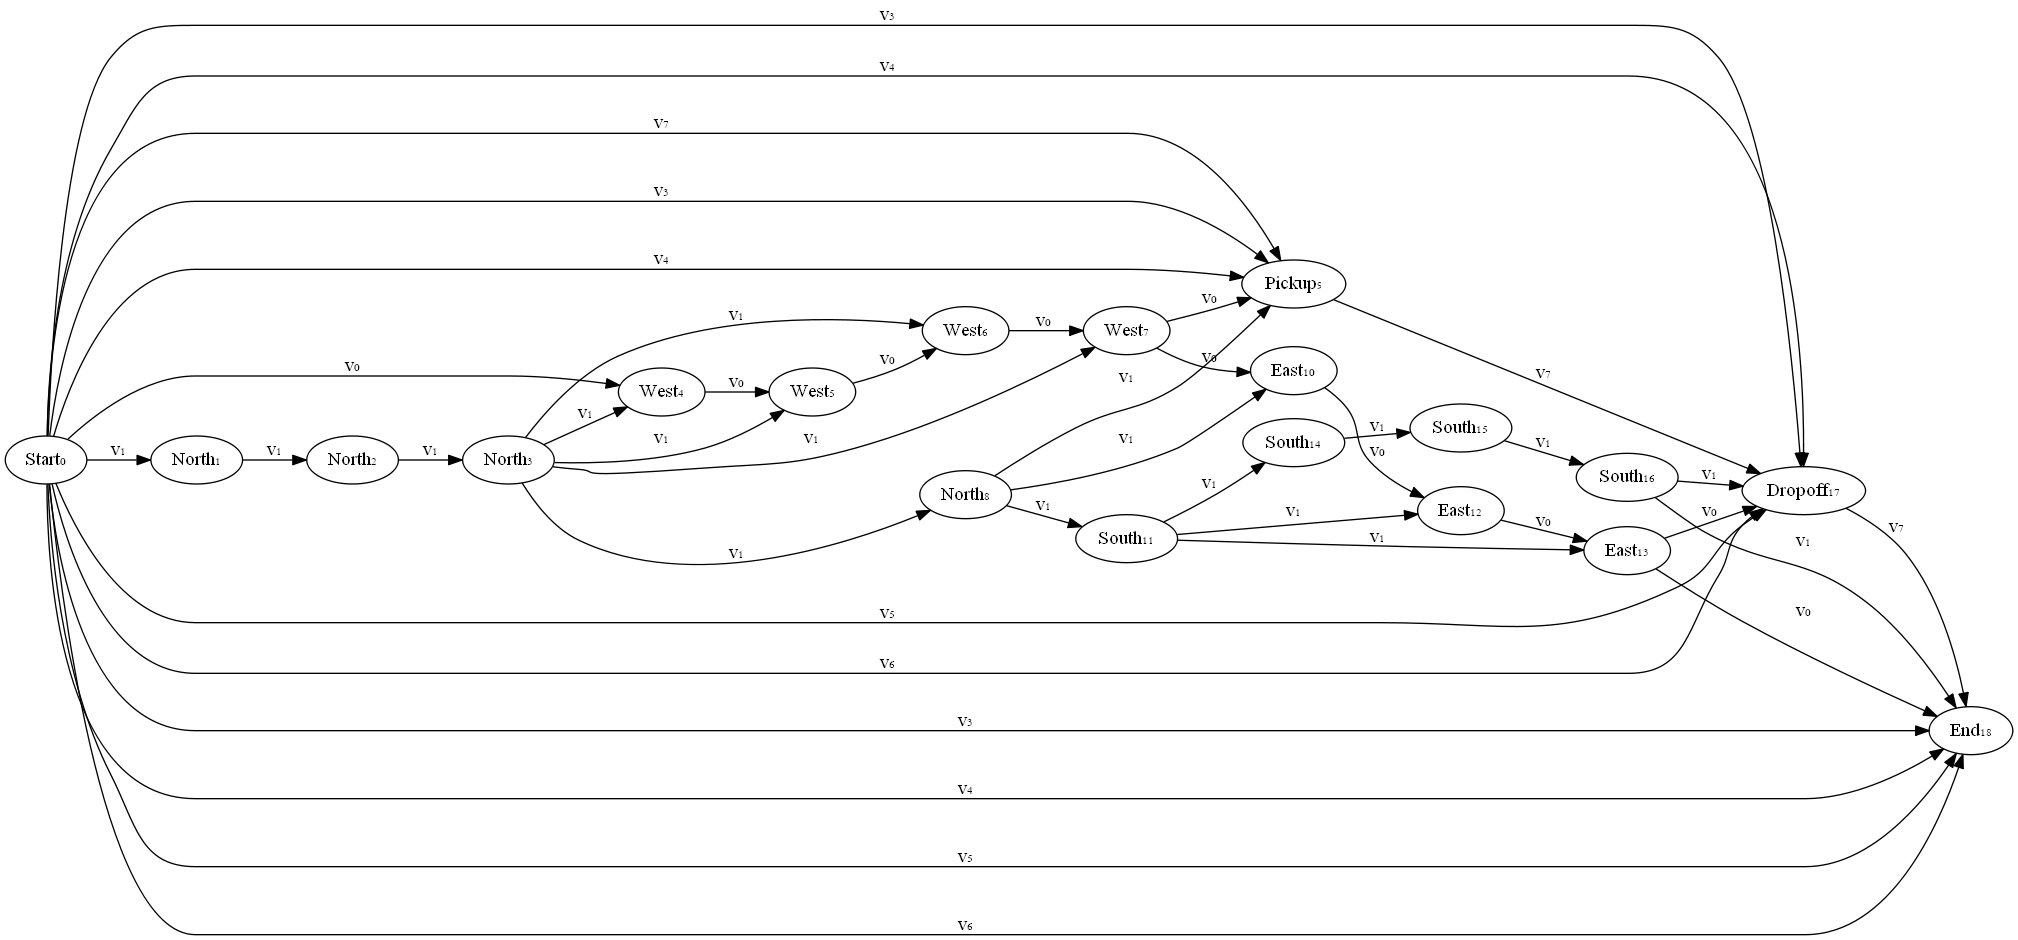

In [15]:
omega = [c]
viewTrajectory(omega[0])

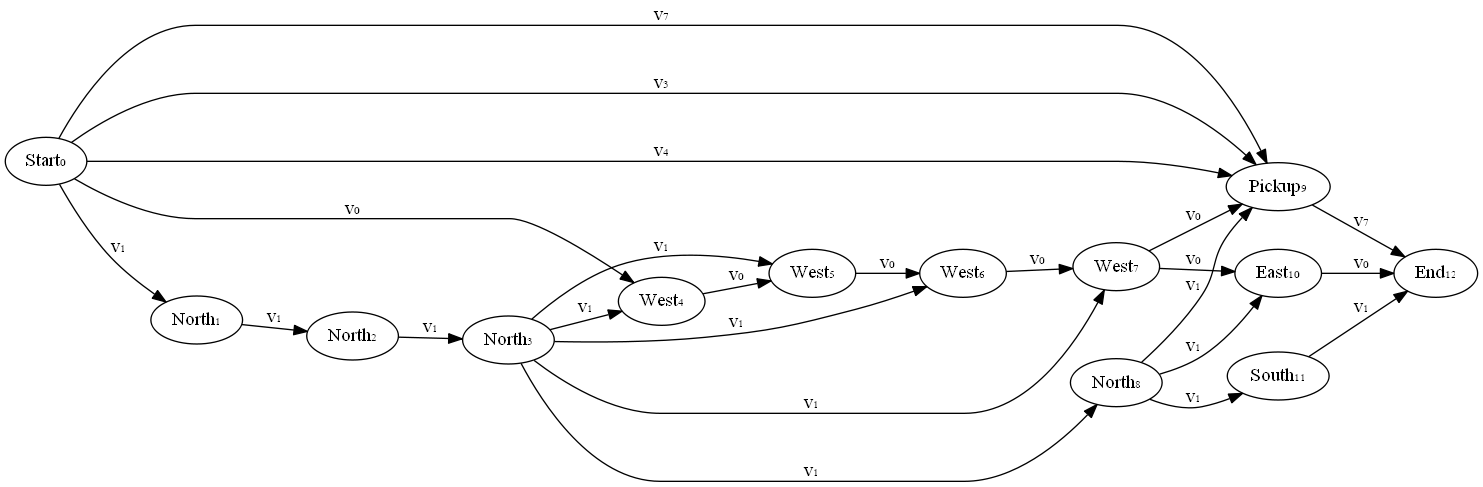

In [16]:
psi_ = [{1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11}]
new = extract(omega, psi_)
viewTrajectory(new[0])

In [27]:
omega = [c]
print(hierGen(mu, omega))

[]
{1, 2, 3}
[[]]
[]
{4, 5, 6, 7}
[[1, 2, 3]]
[]
{1, 2, 3}
[[]]
[]
{4, 5, 6, 7}
[[1, 2, 3]]
[]
{1, 2, 3}
[[]]
[]
{8}
[[1, 2, 3, 4, 5, 6, 7]]
[]
{1, 2, 3}
[[]]
[]
{4, 5, 6, 7}
[[1, 2, 3]]
[]
{1, 2, 3}
[[]]
[]
{4, 5, 6, 7}
[[1, 2, 3]]
[]
{1, 2, 3}
[[]]
[]
{8}
[[1, 2, 3, 4, 5, 6, 7]]
[]
{9}
[[1, 2, 3, 4, 5, 6, 7, 8]]
[]
{10}
[[1, 2, 3, 4, 5, 6, 7, 8, 9]]
[]
{1, 2, 3}
[[]]
[]
{4, 5, 6, 7}
[[1, 2, 3]]
[]
{1, 2, 3}
[[]]
[]
{4, 5, 6, 7}
[[1, 2, 3]]
[]
{1, 2, 3}
[[]]
[]
{8}
[[1, 2, 3, 4, 5, 6, 7]]
[]
{1, 2, 3}
[[]]
[]
{4, 5, 6, 7}
[[1, 2, 3]]
[]
{1, 2, 3}
[[]]
[]
{4, 5, 6, 7}
[[1, 2, 3]]
[]
{1, 2, 3}
[[]]
[]
{8}
[[1, 2, 3, 4, 5, 6, 7]]
[]
{9}
[[1, 2, 3, 4, 5, 6, 7, 8]]
[]
{10}
[[1, 2, 3, 4, 5, 6, 7, 8, 9]]
[]
{1, 2, 3}
[[]]
[]
{4, 5, 6, 7}
[[1, 2, 3]]
[]
{1, 2, 3}
[[]]
[]
{8}
[[1, 2, 3, 4, 5, 6, 7]]
[]
{1, 2, 3}
[[]]
[]
{4, 5, 6, 7}
[[1, 2, 3]]
[]
{1, 2, 3}
[[]]
[]
{4, 5, 6, 7}
[[1, 2, 3]]
[]
{1, 2, 3}
[[]]
[]
{8}
[[1, 2, 3, 4, 5, 6, 7]]
[]
{9}
[[1, 2, 3, 4, 5, 6, 7, 8]]
[]
{11}
[[1, 2, 3, 4, 

[]
{1, 2, 3}
[[]]
[]
{4, 5, 6, 7}
[[1, 2, 3]]
[]
{1, 2, 3}
[[]]
[]
{4, 5, 6, 7}
[[1, 2, 3]]
[]
{1, 2, 3}
[[]]
[]
{8}
[[1, 2, 3, 4, 5, 6, 7]]
[]
{9}
[[1, 2, 3, 4, 5, 6, 7, 8]]
[]
{10}
[[1, 2, 3, 4, 5, 6, 7, 8, 9]]
[]
{1, 2, 3}
[[]]
[]
{4, 5, 6, 7}
[[1, 2, 3]]
[]
{1, 2, 3}
[[]]
[]
{4, 5, 6, 7}
[[1, 2, 3]]
[]
{1, 2, 3}
[[]]
[]
{8}
[[1, 2, 3, 4, 5, 6, 7]]
[]
{1, 2, 3}
[[]]
[]
{4, 5, 6, 7}
[[1, 2, 3]]
[]
{1, 2, 3}
[[]]
[]
{4, 5, 6, 7}
[[1, 2, 3]]
[]
{1, 2, 3}
[[]]
[]
{8}
[[1, 2, 3, 4, 5, 6, 7]]
[]
{9}
[[1, 2, 3, 4, 5, 6, 7, 8]]
[]
{10}
[[1, 2, 3, 4, 5, 6, 7, 8, 9]]
[]
{1, 2, 3}
[[]]
[]
{4, 5, 6, 7}
[[1, 2, 3]]
[]
{1, 2, 3}
[[]]
[]
{8}
[[1, 2, 3, 4, 5, 6, 7]]
[]
{1, 2, 3}
[[]]
[]
{4, 5, 6, 7}
[[1, 2, 3]]
[]
{1, 2, 3}
[[]]
[]
{4, 5, 6, 7}
[[1, 2, 3]]
[]
{1, 2, 3}
[[]]
[]
{8}
[[1, 2, 3, 4, 5, 6, 7]]
[]
{9}
[[1, 2, 3, 4, 5, 6, 7, 8]]
[]
{11}
[[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]]
[]
{1, 2, 3}
[[]]
[]
{4, 5, 6, 7}
[[1, 2, 3]]
[]
{1, 2, 3}
[[]]
[]
{4, 5, 6, 7}
[[1, 2, 3]]
[]
{1, 2, 3}
[[]]
[]
{8}
[[1,

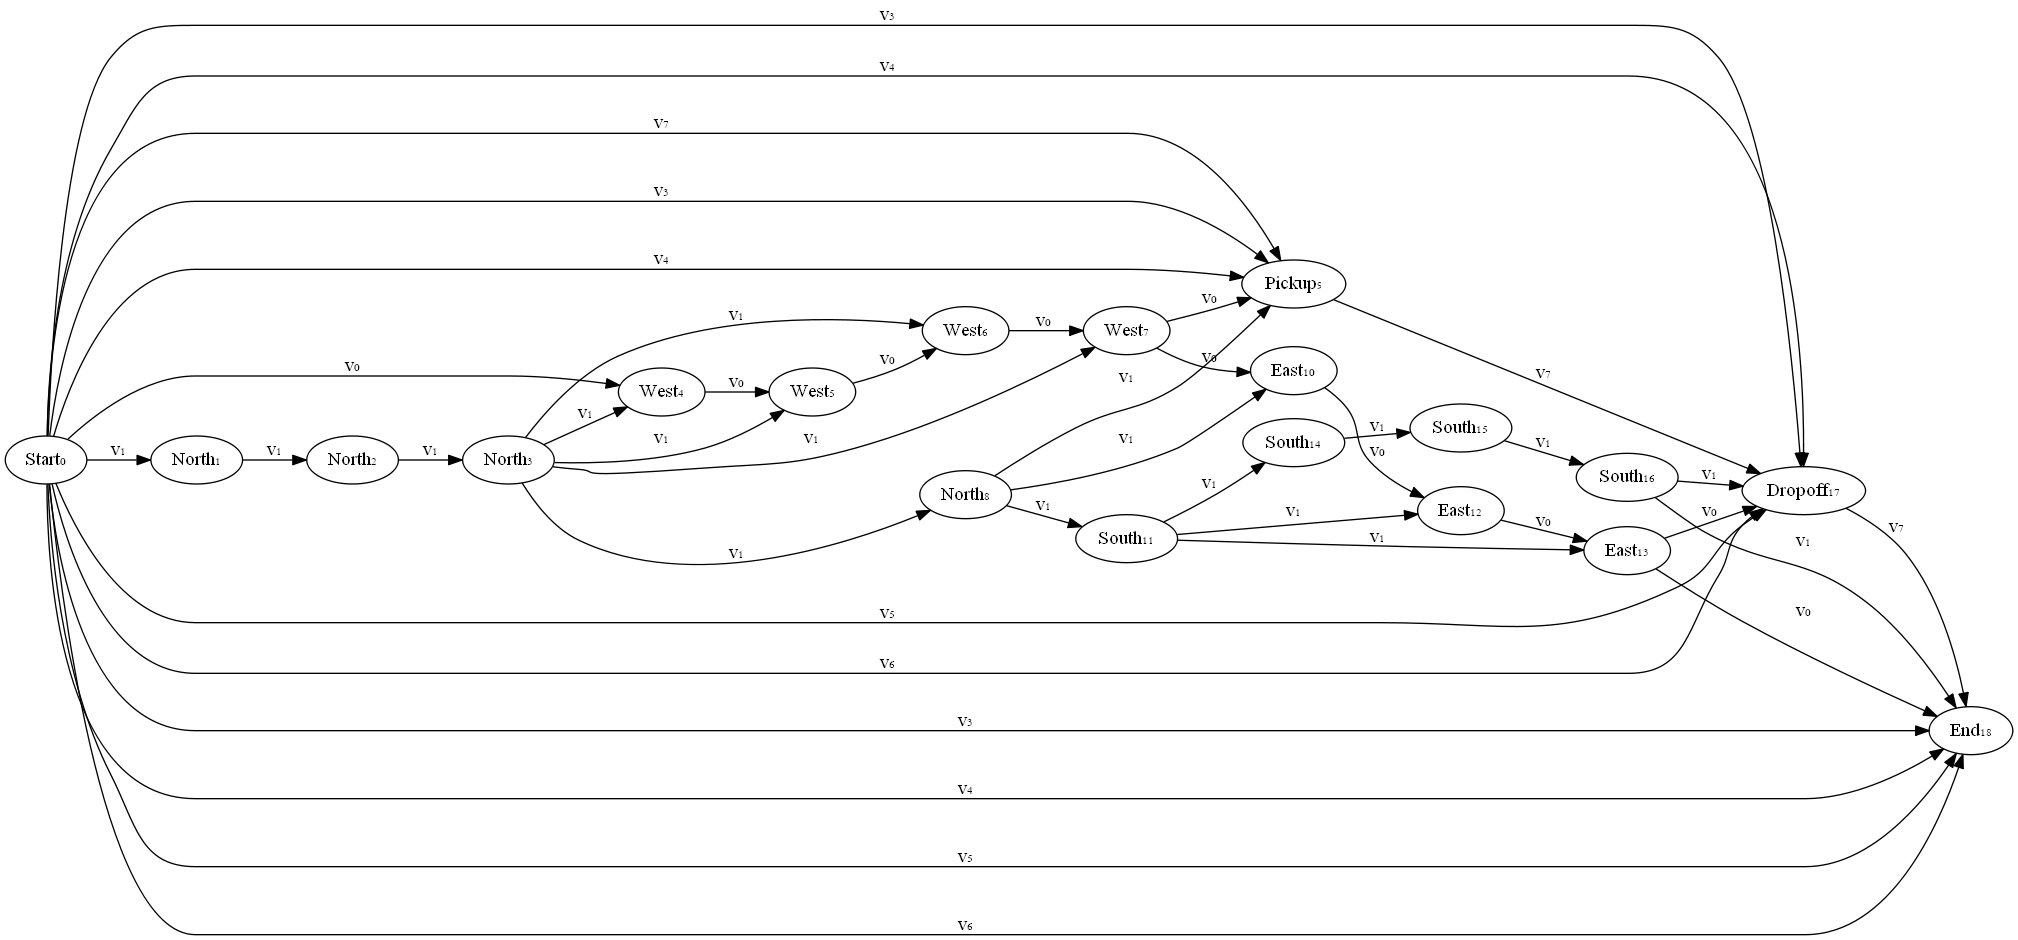

In [25]:
viewTrajectory(omega[0])

In [ ]:
# mu - как изменяется каждая переменная при действии a 
# mu[A] = U mu_a по всем a из A  (ребра выкидываем)
# mu_a = (X U X', E_a), где X - вершины на первой стадии, X' - на второй; E - edges
# relevant variable - v меняется или проверяется при действии a в состоянии s
# G - goal predicate
# V_T(s) - total reward during task T in state s


# ЕЩЕ НУЖНА ПОСТ-ОБРАБОТКА PG (2 действия)